In [1]:
import numpy as np
from numpy import r_
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, norm
from astropy.io import fits
import astropy.constants as const
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.constants import c as C
import astropy.units as u
import astropy.coordinates as astrocoords
from PyAstronomy import pyasl
import glob
from scipy import optimize

%matplotlib notebook

In [3]:
def loadspec(filepath='FITS_Spectra/SDSS1152/VIS/VIS_SPEC_*.fits',
             form='line', cen_wave=656.276, half_v_range=500):
    
    """
    load series of spectra from FITS format and output a datacube in velocity space
    around a chosen wavelength.
    
    filepath is the string common to all desired files,
    default is 'FITS_Spectra/Spectrum_#*.fits'
    cen_wave gives the central wavelength (in nm) of the desired spectral line,
    default is 656.276
    half_v_range gives the range of velocity space (km/s) desired each side of the
    central wavelength, default is 500
    """

    i=0
    nspec = len(glob.glob(filepath))
    f1 = fits.getheader(glob.glob(filepath)[0]) # open header of one image and set values from it
    start = f1['CRVAL1']
    end = start + f1['CDELT1'] * (f1['NAXIS1'] - 1)
    x = np.linspace(start, end, f1['NAXIS1']) # wavelength array
    
    xmax = cen_wave + (half_v_range / (3e5/cen_wave)) # vspace lims
    xmin = cen_wave - (half_v_range / (3e5/cen_wave))
    if form == 'line':
        npoints = len(x[(x > xmin) & (x < xmax)]) # either full spec or between vlims
    elif form == 'full':
        npoints = f1['NAXIS1']

    spec_cube = np.empty((npoints,3,nspec)) # initialise empty array and lists
    BJDlist = []
    BClist = []
    
    for fname in sorted(glob.iglob(filepath)): # open convert and store each spectrum in folder

        f = fits.open(fname)
        head = f[0].header
        flux = f[0].data * 1e17 # convert to more reasonable values to reduce error
        err = f[1].data * 1e17

        start = head['CRVAL1']
        end = start + head['CDELT1'] * (head['NAXIS1'] - 1)
        x = np.linspace(start, end, head['NAXIS1'])
        
        lat = head['HIERARCH ESO TEL GEOLAT'] # telescope details from header
        long = head['HIERARCH ESO TEL GEOLON']
        elev = head['HIERARCH ESO TEL GEOELEV']
        VLT = EarthLocation.from_geodetic(lat, long, elev)
        ra = head['RA']
        dec = head['DEC']
        exp = head['EXPTIME']
        mjdstart = head['MJD-OBS'] # exposure midpoint times
        mjdmid = mjdstart + (exp/(24*60*60*2))
        t = Time(mjdmid, scale='utc', format='mjd')
        
        sc = SkyCoord(ra=ra * u.deg, dec=dec * u.deg) # correct to BJD
        tcorr = t + t.light_travel_time(skycoord=sc, location=VLT)
        tcorr.format = 'jd'
        HelCor = head['HIERARCH ESO QC VRAD BARYCOR']
        BJDlist.append(tcorr.value)
        BClist.append(HelCor)
        
        if form=='line':
            lower_1 = cen_wave - 15
            lower_2 = cen_wave - 8
            upper_1 = cen_wave + 8
            upper_2 = cen_wave + 15
            xcut1 = x[(x > lower_1) & (x < lower_2)] # cut neighbouring regions to Halpha and stitch together
            xcut2 = x[(x > upper_1) & (x < upper_2)]
            ycut1 = flux[(x > lower_1) & (x < lower_2)]
            ycut2 = flux[(x > upper_1) & (x < upper_2)]

            xcut = np.concatenate((xcut1,xcut2))
            ycut = np.concatenate((ycut1,ycut2))
            p = np.polyfit(xcut, ycut, 1) # fit linear continuum
            pfit = np.poly1d(p)

            xline = x[(x > xmin) & (x < xmax)] # extract line region
            yline = flux[(x > xmin) & (x < xmax)]
            errLine = err[(x > xmin) & (x < xmax)]

            ysub = yline / pfit(xline)
            errsub = errLine / pfit(xline)

            vel = (xline - cen_wave) * 3e5/cen_wave # convert to vel space
            velCor = vel + HelCor

            spec_cube[:,:,i] = np.array([velCor, ysub, errsub]).T
            
        elif form=='full':
            spec_cube[:,:,i] = np.array([x, flux, err]).T
        
        else:
            print('Invalid "form" provided')
            
        i+=1

    BJDs = np.array(BJDlist).reshape(len(BJDlist))
    BCs = np.array(BClist).reshape(len(BClist))

    return spec_cube, BJDs, BCs, npoints

###########################################################################

def trailplot(datacube, phase, nbins):

    dataGrid = np.copy(datacube)
    datalength = len(dataGrid[:,0,0])
    for n in range(1,62):
        w = interp1d(datacube[:,0,n], datacube[:,1,n],
                                 fill_value='extrapolate')

        dataGrid[:,0,n] = datacube[:,0,0]
        dataGrid[:,1,n] = w(datacube[:,0,0])

    phaseGrid = np.linspace(0,1,nbins+1)

    ydata = np.zeros((nbins,datalength))
    for n in range(len(phaseGrid)-1):
        idxs = np.where((phase >= phaseGrid[n]) & (phase < phaseGrid[n+1]))
        idxs = idxs[0].tolist()

        data = dataGrid[:,1,idxs]

        if len(idxs) == 0:
            meanflux = np.array([0]*datalength)
        else:
            meanflux = np.mean(data[:], axis=1)

        ydata[n,:] = meanflux
    return ydata, nbins

###########################################################################

def mu(phase, K, gamma):
    return K * np.sin(2 * np.pi * phase) + gamma

###########################################################################

def gauss_2(x, K1, phase, a1, a2, sig1, sig2, gamma1, off):
    return ((a1 * np.exp(-(x - mu(phase,K1,gamma1)) ** 2 / (2 * sig1 ** 2)))
            + (a2 * np.exp(-(x - mu(phase,K1,gamma1)) ** 2 / (2 * sig2 ** 2)))
            + off)

###########################################################################

def gauss_4(x, K1, K2, phase, a1, a2, a3, a4, sig1, sig2, sig3, sig4, gamma1, gamma2, off):
    return ((a1 * np.exp(-(x - mu(phase,K1,gamma1)) ** 2 / (2 * sig1 ** 2)))
            + (a2 * np.exp(-(x - mu(phase,K1,gamma1)) ** 2 / (2 * sig2 ** 2)))
            + (a3 * np.exp(-(x - mu(phase,K2,gamma2)) ** 2 / (2 * sig3 ** 2)))
            + (a4 * np.exp(-(x - mu(phase,K2,gamma2)) ** 2 / (2 * sig4 ** 2)))
            + off)

###########################################################################

def red_chisqr(datacube, pars):
    
    phases = phase.tolist()
    xs = []
    ys = []
    errs = []
    for n in range(0, len(datacube[0,0,:])):
        xs.append(datacube[:,0,n])
        ys.append(datacube[:,1,n])
        errs.append(datacube[:,2,n])
    
    (K1,K2,a1,a2,a3,a4,sig1,sig2,sig3,sig4,gamma1,gamma2,off) = pars
    
    diff = np.array([])
    
    for i in range(0,len(datacube[0,0,:])):
        
        diffNew = np.abs((ys[i] - gauss_4(xs[i], K1, K2, phases[i], a1, a2, a3, a4, sig1,
                                          sig2, sig3, sig4, gamma1, gamma2, off)) /errs[i])**2
        diff= np.hstack((diff, diffNew))
    
    chisqr = np.sum(diff)
    ndf = datacube[:,1,:].size - len(pars)
    r_chisqr = (chisqr / ndf)
        
    return r_chisqr, chisqr, ndf

###########################################################################
def chisqr(pars, phase, datacube):

    phases = phase.tolist()
    xs = []
    ys = []
    errs = []
    for n in range(0, len(datacube[0,0,:])):
        xs.append(datacube[:,0,n])
        ys.append(datacube[:,1,n])
        errs.append(datacube[:,2,n])
    (K1,K2,a1,a2,a3,a4,sig1,sig2,sig3,sig4,gamma1,gamma2,off) = pars
    
    diff = np.array([])
    
    for i in range(0,len(datacube[0,0,:])):
        
        diffNew = np.abs((ys[i] - gauss_4(xs[i], K1, K2, phases[i], a1, a2, a3, a4, sig1,
                                          sig2, sig3, sig4, gamma1, gamma2, off)) /errs[i])
        diff= np.hstack((diff, diffNew))
        
    return np.array(diff)

###########################################################################

def MassesFromSemiamplitudes(K1, K1err, K2, K2err, Porb, i, ierr):

    k1 = np.abs(K1) * (u.km / u.s)
    k2 = np.abs(K2) * (u.km / u.s)
    k1e = K2err * (u.km / u.s)
    k2e = K2err * (u.km / u.s)

    q = k1/k2
    q_inv = k2/k1
    qerr = np.sqrt( (k1e / k1)**2 + (k2e / k2)**2 ) * q
    q_inv_err = np.sqrt( (k1e / k1)**2 + (k2e / k2)**2 ) * q_inv
    
    period = Porb * u.day
    G = const.G
    i = i * u.deg
    ierr = ierr * u.deg

    part1 = ( (period.to(u.s)) / (2 * np.pi * G) )
    part2 = (k1 + k2)**3
    part3 = np.sin(i)**3
    Mtot = ( part1 * (part2 / part3) ).to(u.M_sun)

    K1plusK2 = k1 + k2
    K1plusK2err = np.sqrt( (k1e)**2 + (k2e)**2 )
    top3err = 3 * (K1plusK2err / K1plusK2) * K1plusK2**3

    Mtot = ( part1 * (part2 / part3) ).to(u.M_sun)
    MtotErr = Mtot * (top3err / (K1plusK2**3))


    sinErr = np.cos(i) * (ierr).to(u.radian)
    sin3err = 3 * (sinErr / np.sin(i)) * (np.sin(i)**3)

    M_1 = Mtot / (q**-1 + 1)
    M_2 = Mtot / (q + 1)

    M_1err = np.sqrt( (MtotErr / Mtot)**2 + (qerr / q)**2 ) * M_1
    M_2err = np.sqrt( (MtotErr / Mtot)**2 + (qerr / q)**2 ) * M_2

    M1 = ( (period * (k1 + k2)**2 * k2) / (2 * np.pi * G * np.sin(i)**3) ).to(u.M_sun)
    M2 = ( (period * (k1 + k2)**2 * k1) / (2 * np.pi * G * np.sin(i)**3) ).to(u.M_sun)

    M1err = np.sqrt( (2 * K1plusK2err / K1plusK2)**2 + (k2e / k2)**2
                    + (sin3err.value / np.sin(i)**3)**2) * M1
    M2err = np.sqrt( (2 * K1plusK2err / K1plusK2)**2 + (k1e / k1)**2
                    + (sin3err.value / np.sin(i)**3)**2) * M2
    
    M1M2 = M1 * M2
    M1M2err = M1M2 * np.sqrt((M1err/M1)**2 + (M2err/M2)**2)
    
    T_m = ((1.00e7 * (((M1.value + M2.value)**(1/3)) / (M1.value * M2.value))
            * (period.to(u.hour).value**(8/3))) * u.year).to(u.Gyr)
    
    T_m_err = T_m * np.sqrt( (MtotErr / (3 * Mtot))**2 + (M1M2err / M1M2)**2 )
    return q, qerr, q_inv, q_inv_err, M1, M1err, M2, M2err, Mtot, MtotErr, T_m, T_m_err

##############################################################
def fit_printout(pars, cov, datacube):
    
    errs=np.sqrt(np.diag(cov))
    rchisqr, chisq, ndf = red_chisqr(datacube, pars)
    print('K1 = {} +- {} km/s'.format(round(pars[0], 2), round(errs[0], 1)))
    print('K2 = {} +- {} km/s'.format(round(pars[1], 2), round(errs[1], 1)))
    print('Gamma 1 = {} +- {} km/s'.format(round(pars[10], 1), round(errs[10], 1)))
    print('Gamma 2 = {} +- {} km/s'.format(round(pars[11], 1), round(errs[11], 1)))
    print('A1 = {} +- {} km/s'.format(round(pars[2], 4), round(errs[2], 3)))
    print('A2 = {} +- {} km/s'.format(round(pars[3], 4), round(errs[3], 3)))
    print('A3 = {} +- {} km/s'.format(round(pars[4], 4), round(errs[4], 3)))
    print('A4 = {} +- {} km/s'.format(round(pars[5], 4), round(errs[5], 3)))
    print('S1 = {} +- {} km/s'.format(round(pars[6], 1), round(errs[6], 1)))
    print('S2 = {} +- {} km/s'.format(round(pars[7], 1), round(errs[7], 1)))
    print('S3 = {} +- {} km/s'.format(round(pars[8], 1), round(errs[8], 1)))
    print('S4 = {} +- {} km/s'.format(round(pars[9], 1), round(errs[9], 1)))
    print('off = {} +- {}'.format(round(pars[12], 3), round(errs[12], 3)))
    print('')
    print('Chi-squared: {} +- {}'.format(chisq, np.sqrt(2 * ndf)))
    print('NDF: {}'.format(ndf))
    print('Reduced Chi-squared: {} +- {}'.format(round(rchisqr,4),
                                                 round(np.sqrt(2 * ndf)/ndf,4)))

    (q,qerr,q_inv,q_inv_err,M1,M1err,M2,M2err,Mtot,MtotErr, T_merger, T_merg_err) = MassesFromSemiamplitudes(pars[0],errs[0],pars[1],
                                                                       errs[1],P,89.44,0.03)
    print('')
    print('M1 = ', M1.round(3), ' +- ', M1err.round(3))
    print('M2 = ', M2.round(3), ' +- ', M2err.round(3))
    print('Mtot = ', Mtot.round(3), ' +- ', MtotErr.round(3))
    print('q = ', q.round(3), ' +- ', qerr.round(3))
    print('q_inv = ', q_inv.round(3), ' +- ', q_inv_err.round(3))
    print('merger timescale = ', T_merger.round(3), ' +- ', T_merg_err.round(3))

##############################################################

def SubAndShift(datacube, pars, phases, vel, component):

    rawcube = np.copy(datacube)

    if component=='primary':
        for i in range(62):
            rawcube[:,1,i] -= gauss_2(datacube[:,0,i], pars[1], phases[i], pars[4], pars[5],
                                      pars[8], pars[9], pars[11], pars[12])
    
    elif component=='secondary':
        for i in range(62):
            rawcube[:,1,i] -= gauss_2(datacube[:,0,i], pars[0], phases[i], pars[2], pars[3],
                                      pars[6], pars[7], pars[10], pars[12])
    i=0
    for v in vel:
        rawcube[:,0,i] -= v
        i+=1

    cutData = np.zeros((110,3,62))

    for i in range(len(rawcube[0,0,:])):
        ndata = len(rawcube[:,0,i][(rawcube[:,0,i] > -500) & (rawcube[:,0,i] < 500)])

        cutData[:ndata,0,i] = rawcube[:,0,i][(rawcube[:,0,i] > -500) &
                                             (rawcube[:,0,i] < 500)]
        cutData[:ndata,1,i] = rawcube[:,1,i][(rawcube[:,0,i] > -500) &
                                             (rawcube[:,0,i] < 500)]
        cutData[:ndata,2,i] = rawcube[:,2,i][(rawcube[:,0,i] > -500) &
                                             (rawcube[:,0,i] < 500)]

    interpData_v = np.zeros((109,3,62))
    interpData_v = cutData[:109,:,:]

    interp_Data_v = np.zeros((109,3,62))
    for i in range(len(rawcube[0,0,:])):
        f = interp1d(interpData_v[:,0,i], interpData_v[:,1,i], fill_value='extrapolate')
        fe = interp1d(interpData_v[:,0,i], interpData_v[:,2,i], fill_value='extrapolate')

        interp_Data_v[:,0,i] = interpData_v[:109,0,1]
        interp_Data_v[:,1,i] = f(interp_Data_v[:,0,i])
        interp_Data_v[:,2,i] = fe(interp_Data_v[:,0,i])

    err_v = np.copy(interp_Data_v[:,2,:])
    var_v = err_v**2
    weights_v = np.ones(interp_Data_v[:,2,:].shape)
    weights_v = weights_v / var_v
    weightSum_v = np.sum(weights_v, axis=1)
    fxw_v = interp_Data_v[:,1,:] * weights_v
    fxwSum_v = np.sum(fxw_v, axis=1)
    wmean_v = fxwSum_v/weightSum_v
    werr_v = np.sqrt(1 / weightSum_v)

    mean = np.mean(interp_Data_v[:,1,:], axis=1)
    median = np.median(interp_Data_v[:,1,:], axis=1)
    std = np.std(interp_Data_v[:,1,:], axis=1)
    
    return interp_Data_v, interpData_v, wmean_v, werr_v, mean, median, std

##############################################################
    
def SpecThruFilt(wavelength, flux):
    
    uWL, uTrans = np.loadtxt('Flux_Calibration/SLOAN_SDSS.u.dat', unpack=True)
    gWL, gTrans = np.loadtxt('Flux_Calibration/SLOAN_SDSS.g.dat', unpack=True)
    rWL, rTrans = np.loadtxt('Flux_Calibration/SLOAN_SDSS.r.dat', unpack=True)
    iWL, iTrans = np.loadtxt('Flux_Calibration/SLOAN_SDSS.i.dat', unpack=True)
    zWL, zTrans = np.loadtxt('Flux_Calibration/SLOAN_SDSS.z.dat', unpack=True)
    uWL /= 10 
    gWL /= 10
    rWL /= 10
    iWL /= 10
    zWL /= 10
    
    u = interp1d(uWL,uTrans, fill_value=0, bounds_error=False)
    g = interp1d(gWL,gTrans, fill_value=0, bounds_error=False)
    r = interp1d(rWL,rTrans, fill_value=0, bounds_error=False)
    i = interp1d(iWL,iTrans, fill_value=0, bounds_error=False)
    z = interp1d(zWL,zTrans, fill_value=0, bounds_error=False)
    
    uFlux = flux * u(wavelength)
    gFlux = flux * g(wavelength)
    rFlux = flux * r(wavelength)
    iFlux = flux * i(wavelength)
    zFlux = flux * z(wavelength)
    
    F_lam = np.vstack((uFlux,gFlux,rFlux,iFlux,zFlux))
    T_lam = np.vstack((u(wavelength),g(wavelength),r(wavelength),i(wavelength),z(wavelength)))
    
    return F_lam, T_lam

##############################################################

def FluxMatch(refWave, refFlux, obsFlux, polyOrder=2):
    
    p = np.polyfit(refWave, refFlux/obsFlux, polyOrder)
    
    return p

##############################################################

def SED(pars, wave, flux):

    list(pars)
    cor = np.poly1d(pars)
    correctedFlux = flux * cor(wave)
    F, T = SpecThruFilt(wave, correctedFlux)
    
    
    flux_sum = np.zeros((5))
    trans_sum = np.zeros((5))
    
    i=0
    while i < 5:
        F[i,:] *= wave * 10

        flux_sum[i] = np.sum(F[i,:])
        trans_sum[i] = np.sum(T[i,:] * wave * 10)
        i+=1

    SED = flux_sum/trans_sum
    
    return SED

##############################################################

def residualOffset(pars, wave, flux):

    sed = SED(pars, wave, flux)

    diff = SDSSflux[:,1] - sed
    
    return diff

In [98]:
spec_cube, BJDs, _, npoints = loadspec()
# spec_cube[:,2,:] *= 1.07445 # correction to make reduced chi^2=1
t0 = 2457461.1510313
P = 0.09986516275

phase = (((BJDs - t0)%P)/P)

In [99]:
par_init = np.array([-100,140,-0.2,-0.2,-0.01,-0.01,36,200,20,200,60.3,40,0.75])
p, cov, _, _, _ = leastsq(chisqr, par_init, args=(phase, spec_cube), full_output=True)

In [100]:
fit_printout(p, cov, spec_cube)

K1 = -190.56 +- 1.5 km/s
K2 = 208.32 +- 7.4 km/s
Gamma 1 = 60.6 +- 1.0 km/s
A1 = -0.1491 +- 0.005 km/s
A2 = -0.1043 +- 0.004 km/s
A3 = -0.0267 +- 0.006 km/s
A4 = -0.0402 +- 0.003 km/s
S1 = 31.7 +- 1.4 km/s
S2 = 198.4 +- 9.8 km/s
S3 = 25.4 +- 6.7 km/s
S4 = 180.9 +- 20.6 km/s
off = 0.758 +- 0.004

Chi-squared: 7789.254231735303 +- 116.15506876585283
NDF: 6746
Reduced Chi-squared: 1.1546 +- 0.0172

M1 =  0.343 solMass  +-  0.022 solMass
M2 =  0.314 solMass  +-  0.02 solMass
Mtot =  0.657 solMass  +-  0.051 solMass
q =  0.915  +-  0.048
q_inv =  1.093  +-  0.057
merger timescale =  0.831 Gyr  +-  0.078 Gyr


In [101]:
v1, v2 = (mu(phase, p[0], p[10]), mu(phase, p[1], p[11]))

In [102]:
newspec, _, _, npoints2  = loadspec(half_v_range=1000)

In [105]:
interpData1,interpdata1,wmean3,werr3,mean3,median3,std3 = SubAndShift(newspec, p, phase, v1,
                                                                      component='primary')
interpData2,interpdata2,wmean4,werr4,mean4,median4,std4 = SubAndShift(newspec, p, phase, v2,
                                                                      component='secondary')

<IPython.core.display.Javascript object>


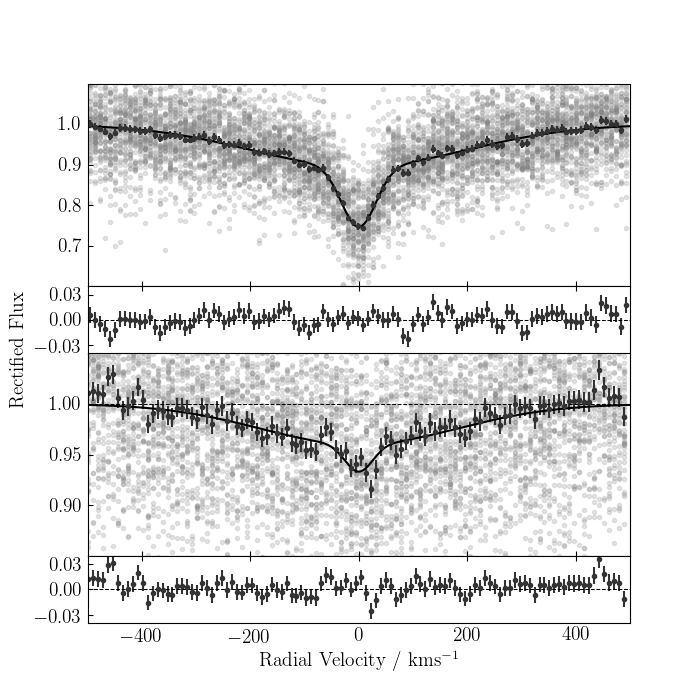

In [106]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 14

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(7,7), sharex=True,
                                      gridspec_kw = {'height_ratios':[3,1,3,1]})

for i in range(len(interpData1[0,0,:])):
    ax1.scatter(interpData1[:,0,i], interpData1[:,1,i]+1, marker='.', c='0.5', alpha=0.2)
    
ax1.errorbar(interpData1[:,0,i],wmean3+1, yerr=werr3, marker='.', color='0.2',
             markersize=6, elinewidth=1.5, lw=0)

x = np.linspace(-500,500,1000)
y1 = gauss_2(x, 0, 0, p[2], p[3], p[6], p[7], 0, 0)
y_1 = gauss_2(interpData1[:,0,i], 0, 0, p[2], p[3], p[6], p[7], 0, 0)
ax1.plot(x,y1+1,'k')
# ax1.hlines(1,-500,500,'k','--', lw=0.75)
ax1.set_ylim([0.64,1.12])
ax1.set_xlim([-500,500])

for i in range(len(interpData2[0,0,:])):
    ax3.scatter(interpData2[:,0,i], interpData2[:,1,i]+1, marker='.', c='0.5', alpha=0.2)
    
ax3.errorbar(interpData2[:,0,i],wmean4+1, yerr=werr4, marker='.', color='0.2',
             markersize=6, elinewidth=1.5, lw=0)

ax3.set_ylim([0.87,1.05])
y2 = gauss_2(x, 0, 0, p[4], p[5], p[8], p[9], 0, 0)
y_2 = gauss_2(interpData2[:,0,i], 0, 0, p[4], p[5], p[8], p[9], 0, 0)

ax4.set_xlabel('Radial Velocity / kms$^{-1}$')
ax3.plot(x,y2+1,'k')
ax3.hlines(1,-500,500,'k','--', lw=0.75)
ax3.set_xlim([-500,500])

ax2.errorbar(interpData1[:,0,i],wmean3-y_1, yerr=werr3, marker='.', color='0.2',
             markersize=6, elinewidth=1.5, lw=0)
ax2.hlines(0,-500,500,'k','--', lw=0.75)
ax4.errorbar(interpData2[:,0,i],wmean4-y_2, yerr=werr4, marker='.', color='0.2',
             markersize=6, elinewidth=1.5, lw=0)
ax4.hlines(0,-500,500,'k','--', lw=0.75)

ax1.set_yticks([0.7,0.8,0.9,1])
ax1.tick_params(direction='in',bottom=True)
ax1.set_ylim([0.6,1.1])
ax2.set_yticks([-0.03,0,0.03])
ax2.tick_params(direction='in',top=True,bottom=False)
ax2.set_ylim([-0.04,0.04])
ax3.set_yticks([0.9,0.95,1])
ax3.tick_params(direction='in',bottom=True)
ax3.set_ylim([0.85,1.05])
ax4.set_yticks([-0.03,0,0.03])
ax4.tick_params(direction='in',top=True,bottom=False)
ax4.set_ylim([-0.04,0.04])

fig.text(0.015, 0.5, 'Rectified Flux', va='center', rotation='vertical')
plt.subplots_adjust(hspace=0)
plt.show()
# fig.savefig('Halpha+residuals3.pdf')

In [107]:
trail1 = np.copy(newspec)
trail2 = np.copy(newspec)
trail3 = np.copy(newspec)
trail4 = np.copy(newspec)
trail5 = np.copy(newspec)
for i in range(62):
    trail1[:,1,i] = newspec[:,1,i] - gauss_2(newspec[:,0,i], p[1], phase[i], p[4],
                                             p[5], p[8], p[9], p[11], p[12])
    trail2[:,1,i] = newspec[:,1,i] - gauss_2(newspec[:,0,i], p[0], phase[i], p[2],
                                             p[3], p[6], p[7], p[10], p[12])
    trail3[:,1,i] = gauss_4(newspec[:,0,i], p[0], p[1], phase[i], p[2], p[3], p[4],
                            p[5], p[6], p[7], p[8], p[9], p[10], p[11], 0)
    trail4[:,1,i] = newspec[:,1,i] - gauss_4(newspec[:,0,i], p[0], p[1], phase[i], p[2], p[3], p[4],
                                             p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12])

In [108]:
nbins = 30
img1, nbins = trailplot(trail1, phase, nbins)
img2, nbins = trailplot(trail2, phase, nbins)
img3, nbins = trailplot(trail3, phase, nbins)
img4, nbins = trailplot(newspec, phase, nbins)
img5, nbins = trailplot(trail4, phase, nbins)

<IPython.core.display.Javascript object>


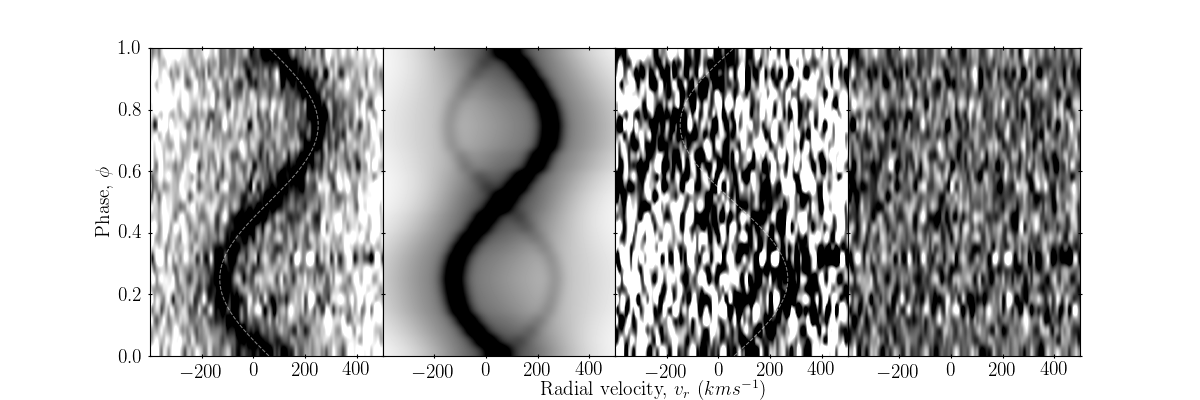

In [111]:
phs=np.linspace(0,1,1000)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,4), sharey=True)

traild = ax1.imshow(img4, cmap ='gray', aspect='auto', origin='lower',
                  norm=matplotlib.colors.Normalize(vmin=p[12]-0.2, vmax=p[12], clip=False),
                  extent=(trail3[:,0,0].min(),trail3[:,0,0].max(),0,1),
                    interpolation='gaussian')

trailr = ax2.imshow(img3, cmap ='gray', aspect='auto', origin='lower',
                  norm=matplotlib.colors.Normalize(vmin=-0.2, vmax=0.0, clip=False),
                  extent=(trail3[:,0,0].min(),trail3[:,0,0].max(),0,1),
                    interpolation='gaussian')

trailp = ax3.imshow(img2, cmap ='gray', aspect='auto', origin='lower',
                  norm=matplotlib.colors.Normalize(vmin=-0.05, vmax=0.01),
                  extent=(trail1[:,0,0].min(),trail1[:,0,0].max(),0,1),
                    interpolation='gaussian') # -0.01,0,0.01,0.02,0.03

trailm = ax4.imshow(img5, cmap ='gray', aspect='auto', origin='lower',
                  norm=colors.Normalize(vmin=-0.061, vmax=0.102),
                  extent=(trail4[:,0,0].min(),trail4[:,0,0].max(),0,1),
                    interpolation='gaussian')

ax1.plot(mu(phs, p[0], p[10]), phs, 'w--', lw=0.75, alpha=0.5)
# ax3.plot(mu(phs, p[0], p[10]), phs, 'w--', lw=0.75, alpha=0.6)
ax3.plot(mu(phs, p[1], p[11]), phs, 'w--', lw=0.75, alpha=0.5)
ax1.set_xlim([-400,500])
ax2.set_xlim([-400,500])
ax3.set_xlim([-400,500])
ax4.set_xlim([-400,500])
ax1.set_xticks([-200,0,200,400])
ax1.tick_params(direction='inout', top=True)
ax2.set_xticks([-200,0,200,400])
ax2.tick_params(direction='inout',top=True)
ax3.set_xticks([-200,0,200,400])
ax3.tick_params(direction='inout',top=True)
ax4.set_xticks([-200,0,200,400])
ax4.tick_params(direction='inout',top=True, right=True)
ax1.set_ylabel('Phase, $\phi$')
plt.subplots_adjust(wspace=0)
fig.text(0.45, 0.02, 'Radial velocity, $v_{r}$ ($kms^{-1}$)',
         va='center', rotation='horizontal')
# fig.savefig('raw_model_secondary.pdf', bbox_inches="tight")

plt.show()

In [15]:
full_specs, BJDs, BCs, Npoints = loadspec(form='full')

In [16]:
full_specs_corrected_v1 = np.copy(full_specs)
full_specs_corrected_v2 = np.copy(full_specs)
for i in range(len(full_specs[0,0,:])):
    shiftFlux_v1, _ = pyasl.dopplerShift(full_specs[:,0,0], full_specs[:,1,i],
                                         v=(BCs[i]-v1[i]),edgeHandling='firstlast')
    full_specs_corrected_v1[:,1,i] = shiftFlux_v1
    
full_summed_v1 = np.mean(full_specs_corrected_v1[:,1,:], axis=1)

In [17]:
filepath_vis = 'FITS_Spectra/SDSS1152/VIS/VIS_SPEC_*.fits'
filepath_uvb='FITS_Spectra/SDSS1152/UVB/UVB_SPEC_*.fits'
UVspec, BJDsUV, BCsUV, NpointsVIS = loadspec(filepath=filepath_uvb,form='full')
VISspec, BJDsVIS, BCsVIS, NpointsVIS  = loadspec(filepath=filepath_vis,form='full')

head1 = fits.getheader('FITS_Spectra/SDSS1152/UVB/UVB_SPEC_01.fits')
head2 = fits.getheader('FITS_Spectra/SDSS1152/VIS/VIS_SPEC_01.fits')

start1 = head1['CRVAL1']
end1 = start1 + head1['CDELT1'] * (head1['NAXIS1'] - 1)
x1 = np.linspace(start1, end1, head1['NAXIS1'])

start2 = head2['CRVAL1']
end2 = start2 + head2['CDELT1'] * (head2['NAXIS1'] - 1)
x2 = np.linspace(start2, end2, head2['NAXIS1'])

fullrange = np.zeros((36054,3,62))
fullrange[36054-head2['NAXIS1']:,:,:] = VISspec # erg/s/cm2/Angstrom
fullrange[:head1['NAXIS1'],:,:] = UVspec

In [18]:
fullrange_v1 = np.copy(fullrange)
for i in range(len(fullrange[0,0,:])):
    shiftFlux_v1, _ = pyasl.dopplerShift(fullrange[:,0,0], fullrange[:,1,i],
                                         v=(BCsUV[i]-v1[i]),edgeHandling='firstlast')
    fullrange_v1[:,1,i] = shiftFlux_v1
    
fullrange_summed_v1 = np.mean(fullrange_v1[:,1,:], axis=1)

In [19]:
SDSSflux = np.loadtxt('Flux_Calibration/fluxes.txt', usecols=(1,2,3))[2:7,:]

In [20]:
spec = 0
par_init = np.array([0,0,1])
params, cov, _, _, _ = leastsq(residualOffset, par_init, full_output=True,
                               args=(fullrange[:,0,spec], fullrange[:,1,spec] * 1e-17))

In [21]:
sed = SED(params, fullrange[:,0,0], fullrange[:,1,0]*1e-17)

In [22]:
flux_corrected_spectra = np.zeros(fullrange.shape)
seds = np.zeros((62,5))
for i in range(len(fullrange[0,0,:])):
    
    par_init = np.array([0,0,1])
    params, cov, _, _, _ = leastsq(residualOffset, par_init, full_output=True,
                                   args=(fullrange[:,0,i], fullrange[:,1,i] * 1e-17))
    pfit = np.poly1d(params)
    flux_corrected_spectra[:,0,i] = fullrange[:,0,i]
    flux_corrected_spectra[:,1,i] = fullrange[:,1,i] * pfit(fullrange[:,0,i])
    flux_corrected_spectra[:,2,i] = fullrange[:,2,i] * pfit(fullrange[:,0,i])
    seds[i,:] = SED([0,0,1],flux_corrected_spectra[:,0,i],flux_corrected_spectra[:,1,i]*1e-17)
print('Done!')

Done!


In [24]:
corrected_v1 = np.copy(flux_corrected_spectra)
for i in range(len(flux_corrected_spectra[0,0,:])):
    shiftCorFlux_v1, _ = pyasl.dopplerShift(flux_corrected_spectra[:,0,0],
                                            flux_corrected_spectra[:,1,i],
                                            v=(BCsUV[i]-v1[i]),edgeHandling='firstlast')
    corrected_v1[:,1,i] = shiftCorFlux_v1
    
corrected_summed_v1 = np.mean(corrected_v1[:,1,:], axis=1)
output_spectrum = np.vstack((corrected_v1[:,0,0], corrected_summed_v1 * 1e-17)).T
output_spectrum = output_spectrum[(output_spectrum[:,0] >= 300) & (output_spectrum[:,0] <= 1000)]
np.savetxt('K1_shifted_flux_corrected_spectrum.txt', output_spectrum)

<IPython.core.display.Javascript object>


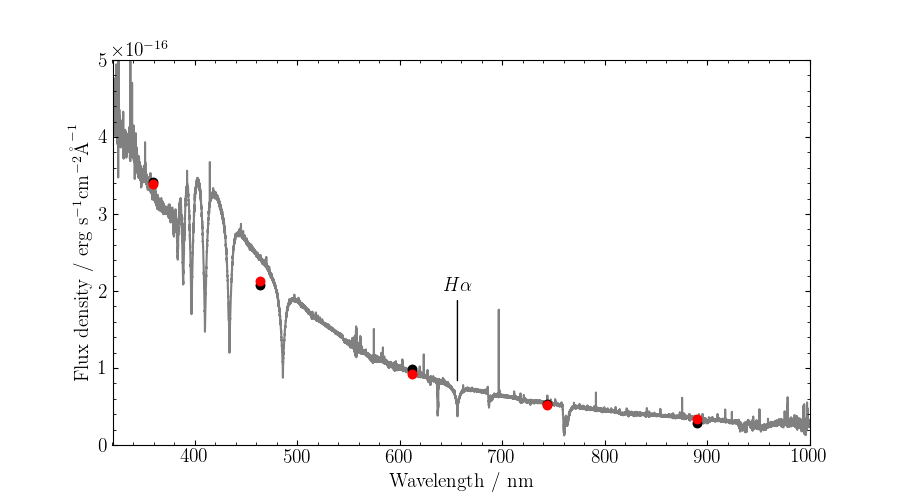

In [90]:
fig, (ax1) = plt.subplots(figsize=(9,5))

matplotlib.rcParams['font.size'] = 14
majorLocatorx = MultipleLocator(100)
minorLocatorx = MultipleLocator(20)
majorLocatory = MultipleLocator(1e-16)
minorLocatory = MultipleLocator(0.2e-16)

ax1.xaxis.set_major_locator(majorLocatorx)
ax1.yaxis.set_major_locator(majorLocatory)

ax1.xaxis.set_minor_locator(minorLocatorx)
ax1.yaxis.set_minor_locator(minorLocatory)
ax1.tick_params(direction='in',which='both',right=True,top=True)

ax1.scatter(SDSSflux[:,0]/10, seds[specnum,:], c='red', zorder=3, marker='.',s=150)
ax1.scatter(SDSSflux[:,0]/10,SDSSflux[:,1], c='0', zorder=2, marker='.',s=150)
ax1.plot(corrected_v1[:,0,0], corrected_summed_v1*1e-17, color='0.5', zorder=1)
ax1.set_ylim([0,5e-16])
ax1.set_xlim([320,1000])
ax1.set_ylabel(r'Flux density / $\mathrm{erg}~ \mathrm{s}^{-1}\mathrm{cm}^{-2}\mathrm{\AA}^{-1}$')
ax1.set_xlabel('Wavelength / nm')
ax1.annotate(r'$H \alpha$',(656.276,0.8e-16),(656.276,2e-16), ha="center", fontsize=14, arrowprops=dict(arrowstyle='-',facecolor='k'))
plt.show()
# fig.savefig('K1_spec_+_SED.pdf')

In [26]:
### OUTPUT FOR MOLLY
full_spectrum, BJDs, BCs, Npoints = loadspec(form='full')

fullspectrum4molly = np.zeros(full_spectrum.shape)
for i in range(len(full_spectrum[0,0,:])):
    newfluxes, _ = pyasl.dopplerShift(full_spectrum[:,0,0], full_spectrum[:,1,i],
                                         v=(BCs[i]),edgeHandling='firstlast')
    
    newerrors, _ = pyasl.dopplerShift(full_spectrum[:,0,0], full_spectrum[:,2,i],
                                         v=(BCs[i]),edgeHandling='firstlast')
    
    fullspectrum4molly[:,0,i] = full_spectrum[:,0,0] * 10
    fullspectrum4molly[:,1,i] = newfluxes
    fullspectrum4molly[:,2,i] = newerrors

    np.savetxt('BC_Raw_Full_spec_#' + str(i+1) + '.txt',fullspectrum4molly[:,:,i])

In [ ]:
fullmodel4molly = np.zeros(full_spectrum.shape)
for i in range(len(full_spectrum[0,0,:])):
    fullmodel4molly[:,0,i] = fullspectrum4molly[:,0,0]
    x = ((fullspectrum4molly[:,0,0]/10) - 656.276) * 3e5/656.276
    y = gauss_4(x, -190.6, 205.17, phase[i], -0.1489, -0.1037, -0.0301, -0.04, 31.6, 197.1, -22.7, 181.8, 60.3, 68.1, 0.758)
    fullmodel4molly[:,1,i] = y
#     np.savetxt('full_model_#' + str(i+1) + '.txt', fullmodel4molly[:,:,i])

In [ ]:
def loadspec2(filepath='FITS_Spectra/SDSS1152/VIS/VIS_SPEC_*.fits'):
    """
    load series of spectra from FITS format and output a datacube in velocity space
    around a chosen wavelength.
    
    filepath is the string common to all desired files,
    default is 'FITS_Spectra/Spectrum_#*.fits'
    cen_wave gives the central wavelength (in nm) of the desired spectral line,
    default is 656.276
    half_v_range gives the range of velocity space (km/s) desired each side of the
    central wavelength, default is 500
    """
    cen_wave=656.276
    i=0
    nspec = len(glob.glob(filepath))
    f1 = fits.getheader(glob.glob(filepath)[0])
    start = f1['CRVAL1']
    end = start + f1['CDELT1'] * (f1['NAXIS1'] - 1)
    x = np.linspace(start, end, f1['NAXIS1'])
    
#     xmax = cen_wave + (half_v_range / (3e5/cen_wave))
#     xmin = cen_wave - (half_v_range / (3e5/cen_wave))

    npoints = f1['NAXIS1']

    spec_cube = np.empty((npoints,3,nspec))
    BJDlist = []
    BClist = []
    
    for fname in sorted(glob.iglob(filepath)):

        f = fits.open(fname)
        head = f[0].header
        flux = f[0].data * 1e17
        err = f[1].data * 1e17

        start = head['CRVAL1']
        end = start + head['CDELT1'] * (head['NAXIS1'] - 1)
        x = np.linspace(start, end, head['NAXIS1'])
        
        lat = head['HIERARCH ESO TEL GEOLAT']
        long = head['HIERARCH ESO TEL GEOLON']
        elev = head['HIERARCH ESO TEL GEOELEV']
        VLT = EarthLocation.from_geodetic(lat, long, elev)
        ra = head['RA']
        dec = head['DEC']
        exp = head['EXPTIME']
        mjdstart = head['MJD-OBS']
        mjdmid = mjdstart + (exp/(24*60*60*2))
        t = Time(mjdmid, scale='utc', format='mjd')
        
        sc = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
        tcorr = t + t.light_travel_time(skycoord=sc, location=VLT)
        tcorr.format = 'jd'
        HelCor = head['HIERARCH ESO QC VRAD BARYCOR']
        BJDlist.append(tcorr.value)
        BClist.append(HelCor)
        
        lower_1 = cen_wave - 15
        lower_2 = cen_wave - 8
        upper_1 = cen_wave + 8
        upper_2 = cen_wave + 15
        xcut1 = x[(x > lower_1) & (x < lower_2)] # 640,650
        xcut2 = x[(x > upper_1) & (x < upper_2)] # 665,680
        ycut1 = flux[(x > lower_1) & (x < lower_2)] # 640,650
        ycut2 = flux[(x > upper_1) & (x < upper_2)] # 665,680

        xcut = np.concatenate((xcut1,xcut2))
        ycut = np.concatenate((ycut1,ycut2))
        p = np.polyfit(xcut, ycut, 1)
        pfit = np.poly1d(p)

#         xline = x[(x > xmin) & (x < xmax)]
#         yline = flux[(x > xmin) & (x < xmax)]
#         errLine = err[(x > xmin) & (x < xmax)]

        fluxsub = flux / pfit(x)
        errsub = err / pfit(x)

        newflux, _ = pyasl.dopplerShift(x*10, fluxsub, v=(HelCor), edgeHandling='firstlast')
        newerr, _ = pyasl.dopplerShift(x*10, errsub, v=(HelCor), edgeHandling='firstlast')

        spec_cube[:,:,i] = np.array([x*10, newflux, newerr]).T
            
        i+=1
        
    return spec_cube